# MNIST Image Classification Using LeNet

In this tutorial, we are going to walk through the logic in `lenet_mnist.py` shown below and provide step-by-step instructions.

In [1]:
!cat lenet_mnist.py

# Copyright 2019 The FastEstimator Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import tempfile

import numpy as np
import tensorflow as tf

import fastestimator as fe
from fastestimator.architecture import LeNet
from fastestimator.op.tensorop import Minmax, ModelOp, SparseCategoricalCrossentropy
from fastestimator.trace import Accuracy, ModelSaver


def get_estimator(epochs=2, batch_s

## Step 1: Prepare training and evaluation dataset, create FastEstimator `Pipeline`

`Pipeline` can take both data in memory and data in disk. In this example, we are going to use data in memory by loading data with `tf.keras.datasets.mnist`

In [2]:
import tensorflow as tf
(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()
print("train image shape is {}".format(x_train.shape))
print("train label shape is {}".format(y_train.shape))
print("eval image shape is {}".format(x_eval.shape))
print("eval label shape is {}".format(y_eval.shape))

train image shape is (60000, 28, 28)
train label shape is (60000,)
eval image shape is (10000, 28, 28)
eval label shape is (10000,)


The convolution layer requires channel dimension (batch, height, width, channel), therefore, we need to expand the training image and evaluation image by one dimension:

In [3]:
import numpy as np
x_train = np.expand_dims(x_train, -1)
x_eval = np.expand_dims(x_eval, -1)
print("train image shape is {}".format(x_train.shape))
print("eval image shape is {}".format(x_eval.shape))

train image shape is (60000, 28, 28, 1)
eval image shape is (10000, 28, 28, 1)


For in-memory data in `Pipeline`, the data format should be a nested dictionary like: {"mode1": {"feature1": numpy_array, "feature2": numpy_array, ...}, ...}. Each `mode` can be either `train` or `eval`, in our case, we have both `train` and `eval`.  `feature` is the feature name, in our case, we have `x` and `y`.

In [4]:
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}

In [5]:
#Parameters
epochs = 2
batch_size = 32
steps_per_epoch = None
validation_steps = None

Now we are ready to define `Pipeline`, we want to apply a `Minmax` online preprocessing to the image feature `x` for both training and evaluation:

In [6]:
import fastestimator as fe
from fastestimator.op.tensorop import Minmax
pipeline = fe.Pipeline(batch_size=batch_size, data=data, ops=Minmax(inputs="x", outputs="x"))

## Step 2: Prepare model, create FastEstimator `Network`

First, we have to define the network architecture in `tf.keras.Model` or `tf.keras.Sequential`, for a popular architecture like LeNet, FastEstimator has it implemented already in [fastestimator.architecture.lenet](https://github.com/fastestimator/fastestimator/blob/master/fastestimator/architecture/lenet.py).  After defining the architecture, users are expected to feed the architecture definition and its associated model name, optimizer and loss name (default to be 'loss') to `FEModel`.

In [7]:
from fastestimator.architecture import LeNet
model = fe.build(model_def=LeNet, model_name="lenet", optimizer="adam", loss_name="loss")

Now we are ready to define the `Network`: given with a batch data with key `x` and `y`, we have to work our way to `loss` with series of operators.  `ModelOp` is an operator that contains a model.

In [8]:
from fastestimator.op.tensorop import ModelOp, SparseCategoricalCrossentropy
network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                          SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

## Step 3: Configure training, create `Estimator`

During the training loop, we want to: 1) measure accuracy for data data 2) save the model with lowest valdiation loss. `Trace` class is used for anything related to training loop, we will need to import the `Accuracy` and `ModelSaver` trace.

In [9]:
import tempfile
from fastestimator.trace import Accuracy, ModelSaver
save_dir = tempfile.mkdtemp()
traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc'),
          ModelSaver(model_name="lenet", save_dir=save_dir, save_best=True)]

Now we can define the `Estimator` and specify the training configuation:

In [10]:
estimator = fe.Estimator(network=network, 
                         pipeline=pipeline, 
                         epochs=epochs, 
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         traces=traces)

## Start Training

In [11]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 2.3004544; 
FastEstimator-Train: step: 100; loss: 0.4547442; examples/sec: 8394.6; progress: 2.7%; 
FastEstimator-Train: step: 200; loss: 0.2030383; examples/sec: 9686.5; progress: 5.3%; 
FastEstimator-Train: step: 300; loss: 0.080203; examples/sec: 10258.1; progress: 8.0%; 
FastEstimator-Train: step: 400; loss: 0.062838; examples/sec: 10273.1; progress: 10.7%; 
FastEstimator-Train: step: 500; loss: 0.0470703; examples/sec: 10405.2; progress: 13.3%

## Inferencing

After training, the model is saved to a temporary folder. we can load the model from file and do inferencing on a sample image.

In [12]:
import os
model_path = os.path.join(save_dir, 'lenet_best_loss.h5')
trained_model = tf.keras.models.load_model(model_path, compile=False)

Randomly get one image from validation set and compare the ground truth with model prediction:

test image idx 565, ground truth: 4
model predicted class is 4


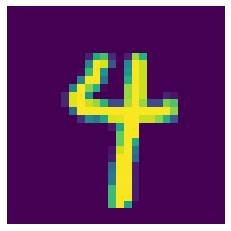

In [14]:
from fastestimator.xai import show_image

selected_idx = np.random.randint(10000)
print("test image idx {}, ground truth: {}".format(selected_idx, y_eval[selected_idx]))
show_image(x_eval[selected_idx])

test_image = x_eval[selected_idx]
test_image = np.expand_dims(test_image, 0)
prediction_score = trained_model.predict(test_image)
print("model predicted class is {}".format(np.argmax(prediction_score)))